In [239]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stt
from scipy.signal import savgol_filter
import random
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Global variables that will remain constant throughout analysis

# Range of delta score (will always be [-1, 1] since scores are percentages between 0-100)
deltaScoreRange = {'min': -1, 'max': 1}

# Maximum reached score difference
maxScoreDelta = 0.5

# Effect size (will be changed to )
es = 0.2

# Zone of proximal development (will always be between the range [0,1])
zpd = 0.25

# Range of sample sizes
n = np.arange(10, 40, 10)

# Number of random samples per sample size
N = 100

# Noise deviation
std = 0.2

# Significance value
significance = 0.05

The relationship between learner-video score difference ($\Delta LV$) and score improvement ($\Delta SI$) is predicted to be given by the following equation:<br>
$\Delta SI = -b_1 (\Delta LV - \Delta LV_{ZPD})^2 + b_0 $<br>
where $b_0$ and $b_1$ are the coeffecients of the polynomial representing the maximal score improvement and the effect size respectively, and $\delta LV_ZPD$ represents the learnver-video score difference zone of proximal development.

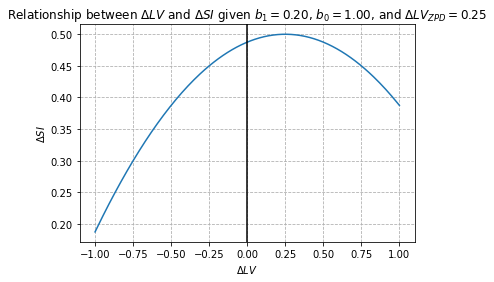

In [240]:
# Returns the deltaScoreImprovement based on the learnerVideoScoreDifference and equation above
def learnerVideoScoreToScoreImprovement(deltaLV):
    return [max(deltaScoreRange['min'], min(deltaScoreRange['max'],(-es * (x - zpd) ** 2) + maxScoreDelta)) for x in deltaLV]

groundTruthData = {}

# Graph to demonstrate relationship betweeb scoreImprovement and learnerVideoScoreDifference
groundTruthData['LV'] = np.arange(-1, 1.01, 0.01)
groundTruthData['SI'] = learnerVideoScoreToScoreImprovement(groundTruthData['LV'])
plt.plot(groundTruthData['LV'], groundTruthData['SI'])

plt.grid(b=True, which='both', axis='both', linestyle='--')
plt.axvline(0, color='black')
plt.xlabel('$\Delta LV$')
plt.ylabel('$\Delta SI$')
ax = plt.title('Relationship between $\Delta LV$ and $\Delta SI$ given $b_1 = $%.2f, $b_0 = $%.2f, and $\Delta LV_{ZPD} = $%.2f' % (es, deltaScoreRange['max'], zpd))

1) Simulate data for video discrepancy/randomly sample from a distribution. I think a uniform distribution may be most fitting. This is because we are assigning the videos given to participants uniformly (so it would be split 33/33/33 across Amateur, Intermediate, and Expert groups). Whilst we are sampling players with fewer hours, I'd still probably go with a score improvement uniformly distributed between [-1,1]. We can always test with a normal distribution skewed towards a positive mean, but the uniform distribution is the more conservative estimate.

2) Then, from this data, simulate the score improvement using a function relating video discrepancy to score improvement. In our case, the function would be a quadratic, but we don't have a good idea as to what shape it will take. However, we can define a shape based on the SEOI (since the coefficient is the amount of curvature => the difference between the peak/off-peak) and even play around with different distributions.

3) Add some random noise to the score improvement using a normal distribution with a mean of 0 (since we'll have the improvement score already) and a variance of some value we can then change and see how it impacts power.

4) Run the statistical test on the data (curve fitting a quadratic and then calculating significance) and record whether the result is significant. Here we use an Ordinary Least Squares model to fit a second degree polynomial curve to the data.

In [241]:
def polynomialModelAndSignificance(X,Y):
    model = np.poly1d(np.polyfit(X,Y,2))
    df = pd.DataFrame(columns=['y','x'])
    df['x'] = X
    df['y'] = Y
    results = smf.ols(formula='y ~ model(x)', data=df).fit()
    return model, results, results.f_pvalue

# Take n samples from a uniform distribution N times between a range (inclusive)
valueRange = deltaScoreRange['max'] - deltaScoreRange['min']

sampleData = {}

for i in n:
    sampleData[i] = {
        'Raw': {},
        'Model': [],
        'StatResults': [],
        'SigValues': []
    }
    sampleData[i]['Raw']['LV'] = {}
    sampleData[i]['Raw']['SI'] = {}

    significanceSum = 0
    
    for j in range(0,N):
        # Generate random samples from a uniform distribution for LV values (step 1)
        sampleData[i]['Raw']['LV'][j] = stt.uniform.rvs(size=i) * valueRange + deltaScoreRange['min']
        # Use LV values, ground truth function, and some randome noise to generate values for SI (steps 2 & 3)
        sampleData[i]['Raw']['SI'][j] = learnerVideoScoreToScoreImprovement(sampleData[i]['Raw']['LV'][j]) + np.random.normal(0, std, i)
        # Fit curve and evaluate F-test p-value (step 4)
        model, results, significanceValue = polynomialModelAndSignificance(sampleData[i]['Raw']['LV'][j], sampleData[i]['Raw']['SI'][j])
        sampleData[i]['Model'].append(model)
        sampleData[i]['StatResults'].append(results)
        sampleData[i]['SigValues'].append(significanceValue)
        # Record whether test was significant
        significanceSum += 1 if significanceValue <= significance else 0
    
    sampleData[i]['SigPercentage'] = significanceSum / N

<BarContainer object of 10 artists>

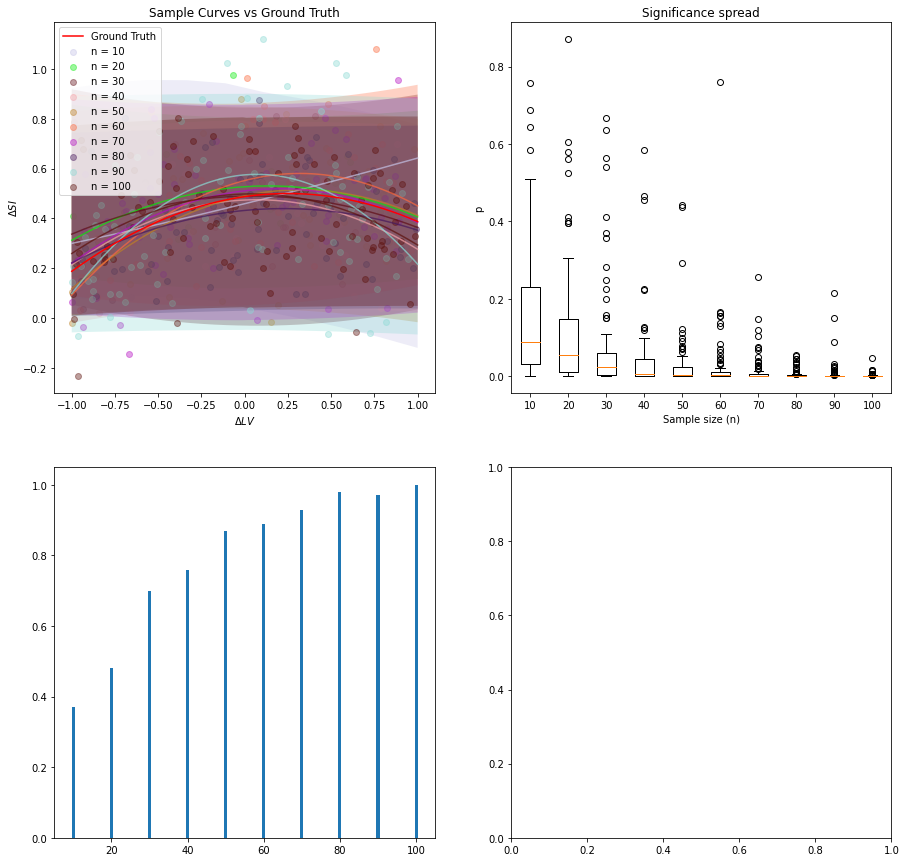

In [242]:
# Plot important information

fig, axs = plt.subplots(2,2,figsize=(15,5))
fig.set_size_inches(15, 15)
axs[0,0].set_title("Sample Curves vs Ground Truth")
axs[0,1].set_title("Significance spread")

bwPlotValueData = []
barPlotPercentageData = []

for i in n:
    rgb = np.random.rand(3,)
    
    for j in range(0,1):
        _,iv_l,iv_u = wls_prediction_std(sampleData[i]['StatResults'][j])
        # Smooth out confidence intervals (data is lost so is purely visual)
        iv_l_hat = savgol_filter(iv_l, len(iv_l)-1, 2)
        iv_u_hat = savgol_filter(iv_u, len(iv_u)-1, 2)
        
        x = np.linspace(-1, 1, len(iv_l))
        
        # Plot confidence, line, and values of sample
        axs[0,0].fill_between(x, iv_u_hat, iv_l_hat, facecolor=(rgb), alpha=0.3)
        axs[0,0].plot(x, sampleData[i]['Model'][j](x), color=(rgb), alpha = 0.7)
        axs[0,0].scatter(sampleData[i]['Raw']['LV'][j], sampleData[i]['Raw']['SI'][j], color=(rgb), alpha=0.4, label="n = " + str(i))
    
    bwPlotValueData.append(sampleData[i]['SigValues'])
    barPlotPercentageData.append(sampleData[i]['SigPercentage'])
        
axs[0,0].plot(groundTruthData['LV'], groundTruthData['SI'], 'r', label="Ground Truth")
axs[0,0].legend(loc='best')
axs[0,0].set_xlabel('$\Delta LV$')
axs[0,0].set_ylabel('$\Delta SI$')

axs[0,1].boxplot(bwPlotValueData)
axs[0,1].set_xticklabels(n)
axs[0,1].set_xlabel('Sample size (n)')
axs[0,1].set_ylabel('p')

axs[1,0].bar(sampleData.keys(), barPlotPercentageData)

#plt.bar(list(isSignificantPercentage.keys()), list(isSignificantPercentage.values()))